# Code Ownership der Teilprojekte

Diese Analyse beschäftigt sich mit dem Verlauf des Code Ownership der einzelnen Teilprojekte. Dabei werden nur die Teilprojekte betrachtet, mit denen sich auch bei der Analyse der Fehlerprotokolle beschäftigt wird.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Dazu wird für jedes Teilprojekt pro Monat ein Durchschnittswert des Code Ownerships gebildet. Falls in einzelnen Monaten keine Entwicklungen innerhalb eines Teilprojektes durchgeführt wurden, wird dieser übersprungen.

Das Code Ownership wird anhand der Anzahl der Commits und geänderten Codezeilen berechnet.
Die entsprechende Formel zu Berechnung des Anteils einer einzelnen Person $P$ zum Zeitpunkt $t$ lautet: 

$
\textrm{Ownership}(P)_t = 
    \frac{
        \frac{\textrm{Commits}(p)_t}{\textrm{Commits} _t}
        +\frac{\textrm{LoCC}(p)_t}{\textrm{LoCC} _t}
    }
    {2}
$

Das Code-Ownership des Teilprojekts ist der maximale Wert aus der Liste der persönlichen Anteile der Beteiligten.

In [1]:
import shared.paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime
from database.models import Commit, ErrorLog, Project
from database.database import Database
from shared.calculation import average, calculate_ownership

database = Database(paths.DATABASE_PATH, cached=True)
results = {}
projects = database.query(Project.LABEL, where("log_groups") != [])

for project in projects:
    if not database.query(ErrorLog.LABEL, where("loggroup").one_of(project.log_groups)):
        continue

    commits = sorted(database.query(Commit.LABEL, where("project_id") == project.id), key=lambda x: x.timestamp)
    project_result = {}
    
    while commits:
        commit = commits.pop(-1)
        if (ownership := calculate_ownership(commits)):
            date = datetime.utcfromtimestamp(commit.timestamp).date().replace(day=1)
            if date not in project_result:
                project_result[date] = []
            project_result[date].append(ownership)
    
    if project_result:
        for date, result in project_result.items():
            project_result[date] = average(result)
        results[project.id] = project_result

## Visualisierung der Daten

Im zweiten Schritt werden die Daten anhand einer kombinierten Ansicht der Projekte in Form von Liniendiagrammen dargestellt. Die Werte der jeweiligen Teilprojekte sind dabei innerhalb des Monats leicht versetzt dargestellt, dies dient nur der Übersichtlichkeit und hat aus Sicht der Daten keine weitere Bedeutung.

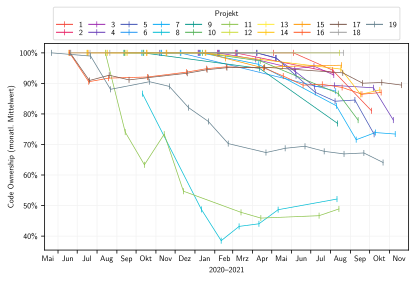

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)
fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, 4))

for index, result in enumerate(results.items()):
    project_id, project_results = result

    sorted_result = dict(sorted(project_results.items()))

    dates = [date.replace(day=int(index+4)) for date in sorted_result.keys()]
    values = list(sorted_result.values())

    ax.plot(dates, values, color=locals.PROJECTS[project_id]["color"],
        label=locals.PROJECTS[project_id]["id"], marker="|", markeredgewidth=0.7, linewidth=0.7)

legend = ax.legend(title="Projekt", loc="upper center", bbox_to_anchor=(0.5, 1.195),
    ncol=10, labelspacing=0.1, columnspacing=.75, edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_linewidth(1)
legend._legend_box.sep = 4

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment("center")

ax.margins(x=0.02)
ax.set_ylabel("Code Ownership (monatl. Mittelwert)")
ax.set_xlabel("2020–2021")
ax.grid(color=locals.GRID_GRAY)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## Erstellung der Wertetabelle

Als letzter Schritt wird die entsprechende Wertetabelle angelegt.

In [3]:
from IPython.display import display, Markdown, HTML
from tabulate import tabulate

table_headers = ["Monat"]
table_rows = []

dates = set()
for result in results.values():
    for date in result.keys():
        dates.add(date)
dates = [date for date in sorted(dates)]
table_headers.extend([f"Projekt {locals.PROJECTS[project_id]['id']}" for project_id in results.keys()])

for date in dates:
    row = [date.strftime("%b %Y")]
    for project_result in results.values():
        row.append(f"{project_result[date]:.2f}" if date in project_result else "-")
    table_rows.append(row)

display(Markdown("**Wertetabelle**"))

display(HTML(tabulate(headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))

**Wertetabelle**

Monat,Projekt 1,Projekt 2,Projekt 3,Projekt 4,Projekt 5,Projekt 6,Projekt 7,Projekt 8,Projekt 9,Projekt 10,Projekt 11,Projekt 12,Projekt 13,Projekt 14,Projekt 15,Projekt 16,Projekt 17,Projekt 18,Projekt 19
Mai 2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.00
Jun 2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.00,1.00,1.00,1.00,-
Jul 2020,-,-,-,-,-,-,-,-,-,-,-,-,1.00,1.00,1.00,0.91,0.91,1.00,0.99
Aug 2020,-,-,-,-,-,-,-,-,-,-,1.00,1.00,-,1.00,-,0.92,0.93,1.00,0.88
Sep 2020,-,-,-,-,-,-,-,-,1.00,1.00,0.74,1.00,-,1.00,-,-,0.91,-,-
Okt 2020,-,-,-,-,-,-,1.00,0.87,1.00,1.00,0.63,-,-,1.00,1.00,0.92,0.92,-,0.91
Nov 2020,-,-,-,1.00,-,1.00,1.00,-,-,-,0.73,-,-,1.00,1.00,-,-,-,0.89
Dez 2020,-,-,-,-,-,1.00,1.00,-,-,-,0.55,-,-,-,-,0.94,0.93,-,0.82
Jan 2021,-,-,1.00,1.00,1.00,-,1.00,0.49,-,1.00,-,-,-,1.00,1.00,0.95,0.94,-,0.78
Feb 2021,-,1.00,1.00,1.00,1.00,-,-,0.39,-,-,-,-,-,-,0.98,0.95,0.95,-,0.70
